<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo">
</center>

# Stacking For Classification with Python

Estimated time needed: **45** minutes

## Objectives

After completing this lab you will be able to:

*   **Understand** what Stacking is and how it works
*   **Understand**  that Random Forests have less Correlation between predictors in their ensemble, improving accuracy
*   **Apply** Stacking
*   **Understand** Hyperparameters selection in  Stacking


Stacking takes several classification models called base learners and uses their output as the input for the meta-classifier. Consider the figure below the base learners $h_{1}(x)$, $h_{2}(x)$, $h_{3}(x)$, and $h_{4}(x)$ has the output $\hat{y}_{1}$, $\hat{y}_{2}$, $\hat{y}_{3}$, $\hat{y}_{4}$. These are used as an input to the meta classifier $H( \hat{y}_{1}, \hat{y}_{2}, \hat{y}_{3}, \hat{y}_{4})$, makes the final prediction $\hat{y}=H( \hat{y}_{1}, \hat{y}_{2}, \hat{y}_{3}, \hat{y}_{4})$.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/module5_Ensemble_Based_Methods/Screen_Shot_2022-01-12_at_9.40.33_PM.png" width="1000" alt="cognitiveclass.ai logo">
</center>
<center>Fig. 1 Stacking takes several classification models called base learners and uses their output as the input for the meta-classifier. </center>


We can train all the models using all the data but this **causes over-fitting**. To get a better idea of how the algorithm works we **use K-fold Cross-validation**. We use K-1 folds to train the base classifiers and the last fold to train the meta classifier. We repeat the process using different combinations of each fold. This is shown in Fig 2 where the color-coded square represents the different runs and folds. Each row represents a different run of K fold cross-validation, each column is one of K folds where K=3. For each column, we use the same color columns to train the classifiers and the different color is used to train the meta classifier.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/module5_Ensemble_Based_Methods/stacking-kfold.png" width="1000" alt="cognitiveclass.ai logo">
</center>
<center>Fig. 2  K-fold Cross-validation to train Stacking classifier. </center>


In [2]:
# All Libraries required for this lab are listed below. The libraries, pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# You will need scikit-learn>=0.22.0 as StackingClassifier does not exist in version <0.22.0
!mamba install -c conda-forge -qy scikit-learn=0.22.1

# Note: If your environment doesn't support "!mamba install", use "!pip install"

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [1]:
import pandas as pd
# import pylab as plt
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

Ignore error warnings


In [2]:
import warnings
warnings.filterwarnings('ignore')

This function will calculate the accuracy of the training and testing data given a model.


In [3]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"trian Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

<h1>Apply   Staking Using   Wine Data  </h1>

The class is an essential factor in determining the quality of the wine; this dataset uses chemical analysis of wines grown in the same region in Italy from three different cultivars. Your task is to determine the class  of the wine using the features from the chemical analysis.
The features or attributes include

<pre>
1) Alcohol
2) Malic acid
3) Ash
4) Alcalinity of ash
5) Magnesium
6) Total phenols
7) Flavanoids
8) Nonflavanoid phenols
9) Proanthocyanins
10)Color intensity
11)Hue
12)OD280/OD315 of diluted wines
13)Proline
</pre>

For more info <a href="https://archive.ics.uci.edu/ml/datasets/wine?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01">here </a>,let's load the dataset:


In [4]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/wine.data",names= ['Class', 'Alcohol', 'Malic acid', 'Ash',
         'Alcalinity of ash' ,'Magnesium', 'Total phenols',
         'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',     'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
         'Proline'])

df.tail()

Class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
173      3    13.71        5.65  2.45               20.5         95   
174      3    13.40        3.91  2.48               23.0        102   
175      3    13.27        4.28  2.26               20.0        120   
176      3    13.17        2.59  2.37               20.0        120   
177      3    14.13        4.10  2.74               24.5         96   

     Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
173           1.68        0.61                  0.52             1.06   
174           1.80        0.75                  0.43             1.41   
175           1.59        0.69                  0.43             1.35   
176           1.65        0.68                  0.53             1.46   
177           2.05        0.76                  0.56             1.35   

     Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
173              7.7  0.64                          1.74      740  
174              7.3  0.70                          1.56      750  
175             10.2  0.59                          1.56      835  
176              9.3  0.60                          1.62      840  
177              9.2  0.61                          1.60      560

We see all the dataset is comprised of numerical values using the method <code>dtypes</code>


In [5]:
df.dtypes

Class                             int64
Alcohol                         float64
Malic acid                      float64
Ash                             float64
Alcalinity of ash               float64
Magnesium                         int64
Total phenols                   float64
Flavanoids                      float64
Nonflavanoid phenols            float64
Proanthocyanins                 float64
Color intensity                 float64
Hue                             float64
OD280/OD315 of diluted wines    float64
Proline                           int64
dtype: object

the column <code>class</code> has the class of the wine, we can use the method <code>unique()</code> to obtain the classes:


In [6]:
df['Class'].unique()

array([1, 2, 3], dtype=int64)

We can examine the correlation between each feature and the class variable. By examining the first row or column we see the features are correlated with the class variable.


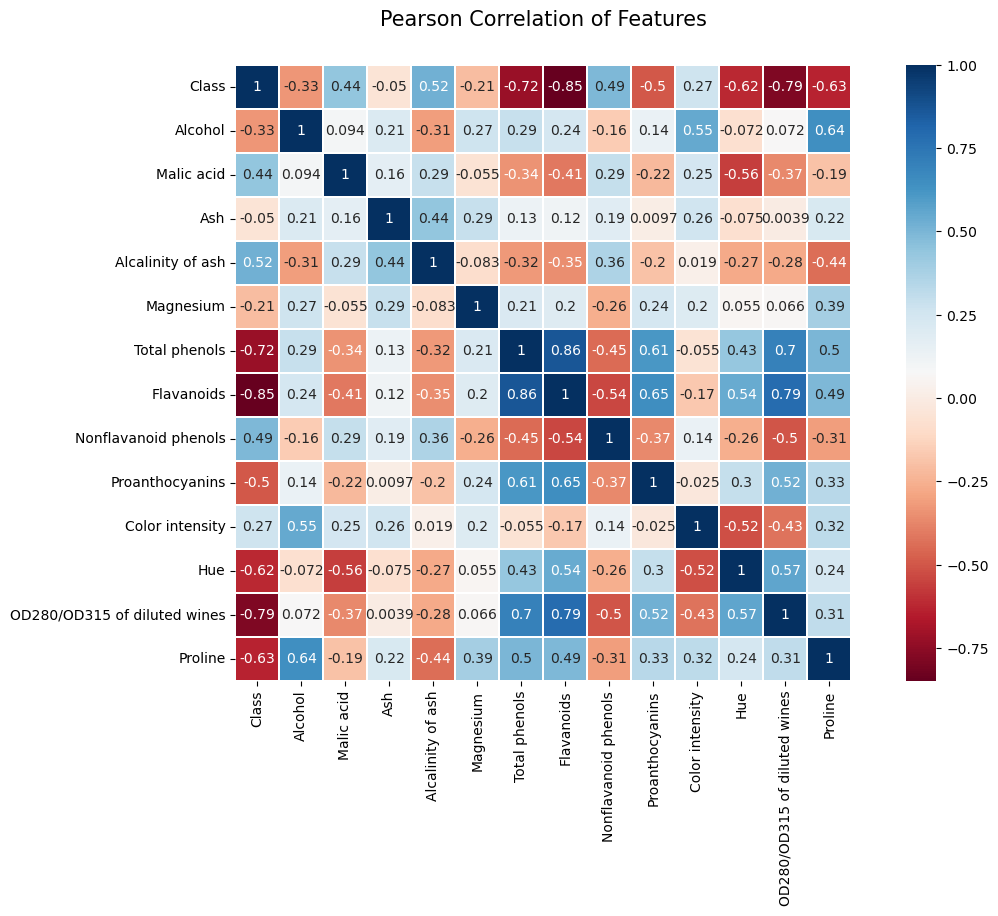

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

We can also examine the <code>Pairplot</code> between pairs of features and the histogram; color-coded to each class. We see the separation between different classes:


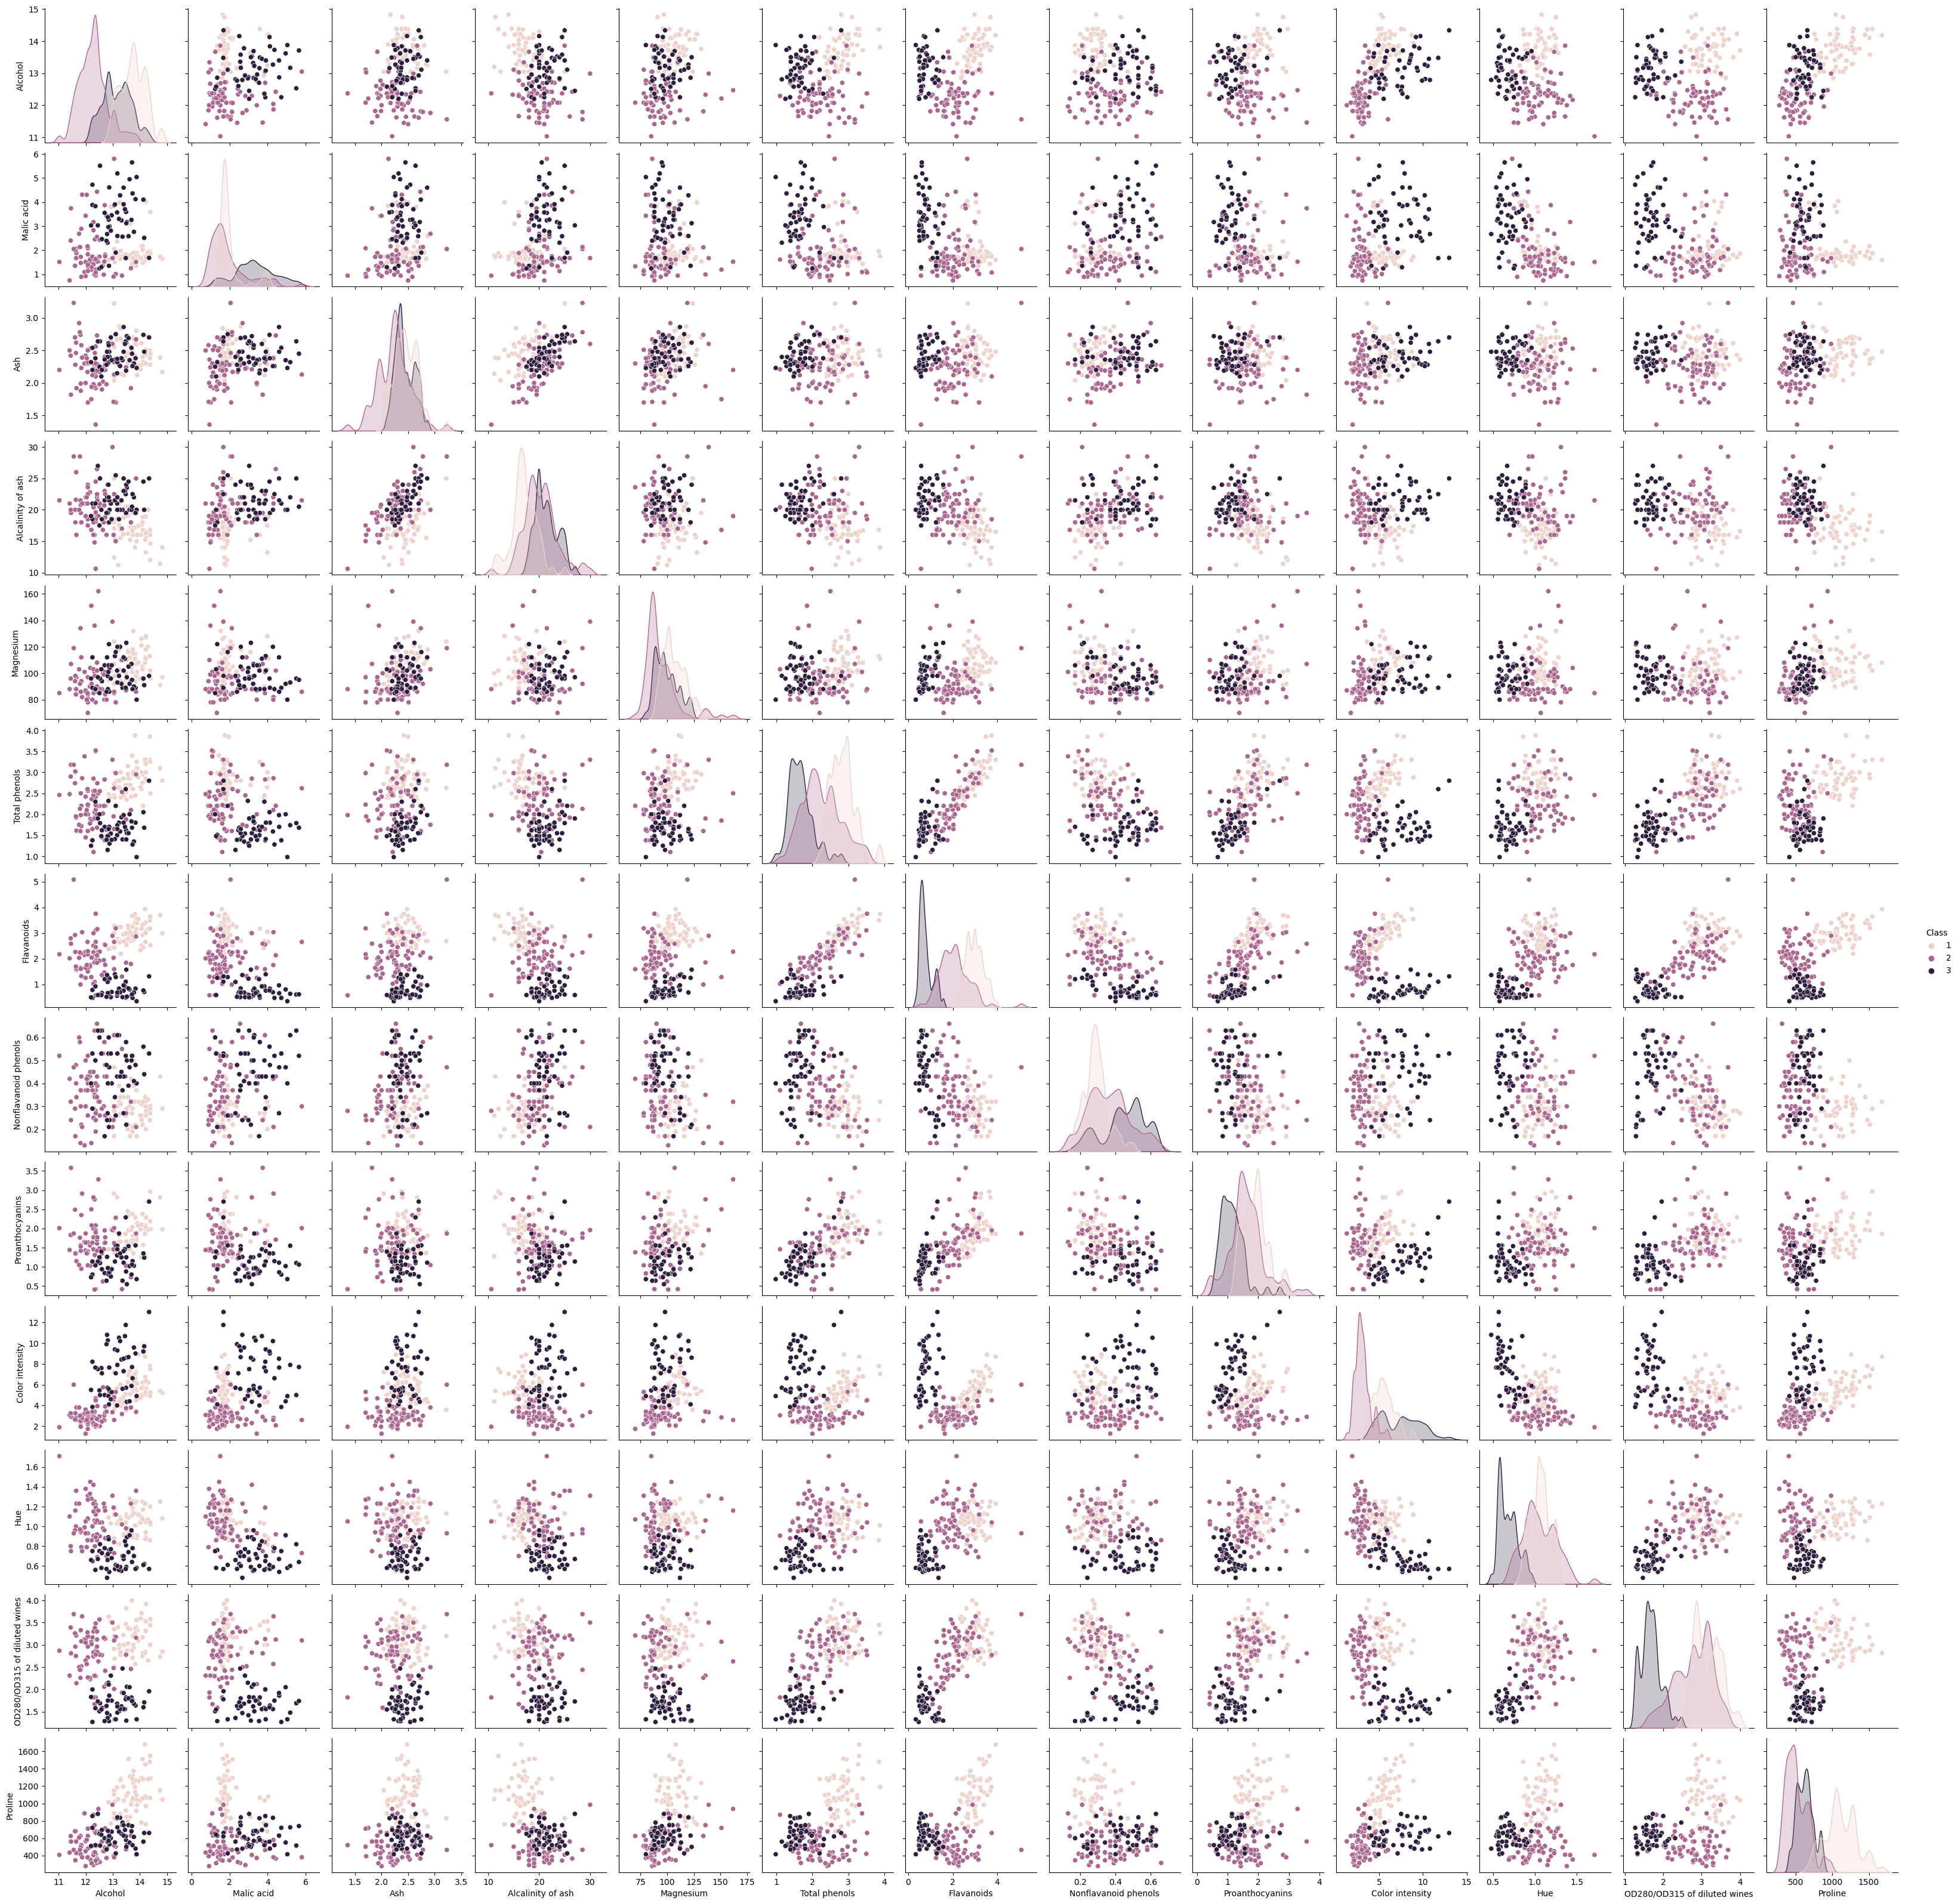

In [12]:
# May need to specify bandwidth (bw) in order to plot, else can delete the `, diag_kws={'bw': 0.2})` code.
sns.pairplot(df, hue="Class", diag_kws={'bw': 0.2})

### Data Pre-Processing and Selection


Let’s examine the feature list


In [13]:
features=list(df)
features[1:]

['Alcohol',
 'Malic acid',
 'Ash',
 'Alcalinity of ash',
 'Magnesium',
 'Total phenols',
 'Flavanoids',
 'Nonflavanoid phenols',
 'Proanthocyanins',
 'Color intensity',
 'Hue',
 'OD280/OD315 of diluted wines',
 'Proline']

We assign the class variables to <code>y</code> and feature variables to <code>X</code>


In [14]:
y,X=df[features[0]] ,df[features[1:]]

We can standardize the data


In [15]:
scaler = preprocessing.StandardScaler().fit(X)
X= scaler.transform(X)

We can check if the data is standardized by checking the mean and standard deviation, which are approximately zero:


In [16]:
X.mean(axis=0)

array([-8.38280756e-16, -1.19754394e-16, -8.37033314e-16, -3.99181312e-17,
       -3.99181312e-17,  0.00000000e+00, -3.99181312e-16,  3.59263181e-16,
       -1.19754394e-16,  2.49488320e-17,  1.99590656e-16,  3.19345050e-16,
       -1.59672525e-16])

In [17]:
X.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In Random Forest, we would use these data subsets to train each node of a tree.


### Train/Test dataset


We split our dataset into train and test set:


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)
print ('Train set', X_train.shape,  y_train.shape)
print ('Test set', X_test.shape,  y_test.shape)

Train set (124, 13) (124,)
Test set (54, 13) (54,)


Stacking consists of creating a Stacking Classifier object, but **first, you require a dictionary of <code>estimators</code>** (individual model objects or base learners). The key of the dictionary is a name that is up to you, we use the usual acronym for the model. The value is the model object in this case SVC for Support Vector Classifier, dt for Decision Tree Classifier and KNN for K Neighbors Classifier.


In [19]:
estimators = [('SVM',SVC(random_state=42)),
              ('KNN',KNeighborsClassifier()),
              ('dt',DecisionTreeClassifier())]
estimators

[('SVM', SVC(random_state=42)),
 ('KNN', KNeighborsClassifier()),
 ('dt', DecisionTreeClassifier())]

To train the final model we create a Stacking Classifier, this combines the base estimators using the meta estimator. The meta-classifier is determined by the parameter <code>final_estimator</code> in this case we use Logistic Regression, we also input the base classifiers using the <code>estimators</code> parameter and fit the model.


In [20]:
clf = StackingClassifier( estimators=estimators, final_estimator= LogisticRegression())
clf.fit(X_train, y_train)
clf

StackingClassifier(estimators=[('SVM', SVC(random_state=42)),
                               ('KNN', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

We can make a prediction


In [21]:
yhat=clf.predict(X_test)
get_accuracy(X_train, X_test, y_train, y_test, clf)

{'test Accuracy': 0.9629629629629629, 'trian Accuracy': 1.0}

<div style="color:red">


<div style="color:red">
   <b> Note: Like most complex models Stacking is prone to overfitting</b>


<h1> GridSearchCV and Stacking Classifiers  </h1>


Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient. You will use GridSearchCV and Stacking Classifiers  to find the best results.


In [26]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv", delimiter=",")
df.head()

Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  drugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  drugY

Let's create the X and y for our dataset:


In [27]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [28]:
y = df["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

Now lets use a <code>LabelEncoder</code> to turn categorical features into numerical:


In [29]:
from sklearn import preprocessing

le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

In [30]:
scaler = preprocessing.StandardScaler().fit(X)
X= scaler.transform(X)

Split the data into training and testing data with a 80/20 split


In [31]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (140, 5) (140,)
Test set: (60, 5) (60,)


We have our dictionary of estimators, the individual model objects or base learners.


In [32]:
estimators = [('SVM',SVC(random_state=42)),
              ('knn',KNeighborsClassifier()),
              ('dt',DecisionTreeClassifier())]
estimators

[('SVM', SVC(random_state=42)),
 ('knn', KNeighborsClassifier()),
 ('dt', DecisionTreeClassifier())]

We create a Stacking Classifier:


In [33]:
clf = StackingClassifier( estimators=estimators, final_estimator= LogisticRegression())
clf

StackingClassifier(estimators=[('SVM', SVC(random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

In order to alter the base models in the dictionary of **hyperparameter** values, we add the key value of each model followed by the parameter of the model we would like to vary.


In [34]:
param_grid = {'dt__max_depth': [n for n in range(10)],
              'dt__random_state':[0],'SVM__C':[0.01,0.1,1],
              'SVM__kernel':['linear', 'poly', 'rbf'],
              'knn__n_neighbors':[1,4,8,9]
             }

search = GridSearchCV(estimator=clf, param_grid=param_grid,scoring='accuracy')
search.fit(X_train, y_train)

search.best_score_
search.best_params_

{'SVM__C': 0.01,
 'SVM__kernel': 'linear',
 'dt__max_depth': 4,
 'dt__random_state': 0,
 'knn__n_neighbors': 1}

In [35]:
get_accuracy(X_train, X_test, y_train, y_test, search)

{'test Accuracy': 0.9666666666666667, 'trian Accuracy': 1.0}

### Thank you for completing this lab!

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Joseph Santarcangelo</a>

### Other Contributors

<a href="https://www.linkedin.com/in/richard-ye/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Richard Ye</a>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |
| ----------------- | ------- | ---------- | --------------------------- |
| 2021-01-01        | 1.0     | Joseph S   | Created the initial version |
| 2022-02-09        | 1.1     | Steve Hord | QA pass                     |
| 2022-05-03        | 1.2     | Richard Ye | Updated sklearn package to `0.22.1` to remove errors |

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>
